Epoch 1, Loss: D=1.0646, G=1.3152


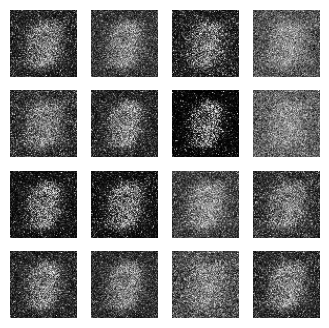

Epoch 2, Loss: D=1.1914, G=0.9052


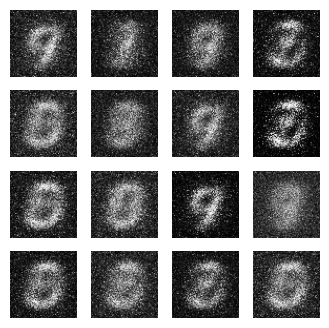

Epoch 3, Loss: D=1.1898, G=0.9891


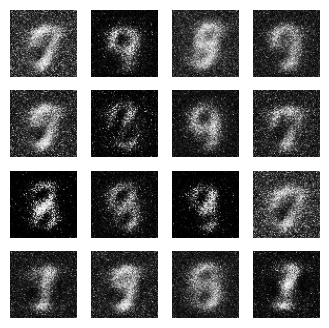

Epoch 4, Loss: D=1.0909, G=1.3590


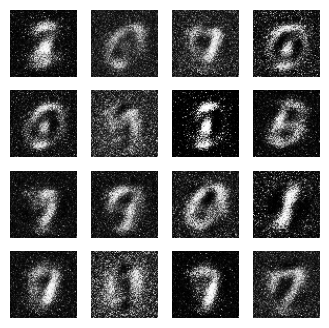

Epoch 5, Loss: D=1.0991, G=0.9541


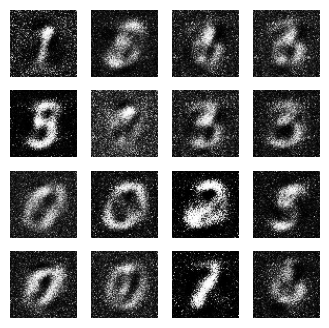

Epoch 6, Loss: D=1.1611, G=0.8554


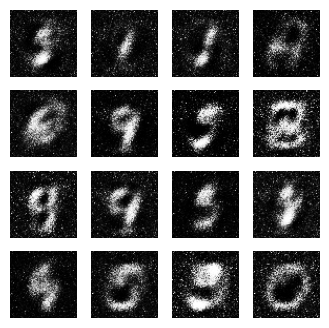

Epoch 7, Loss: D=1.1512, G=1.1146


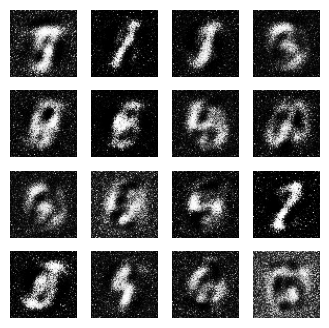

Epoch 8, Loss: D=1.1753, G=0.8177


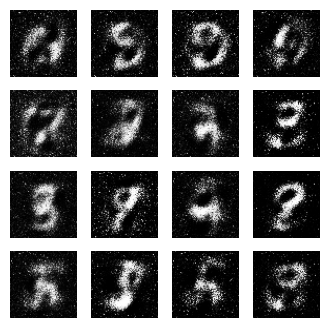

Epoch 9, Loss: D=1.1999, G=0.6914


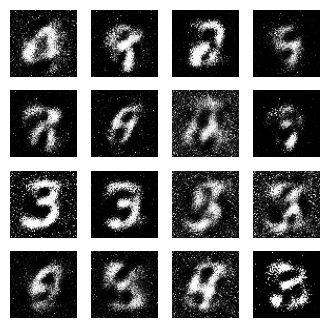

Epoch 10, Loss: D=1.1952, G=0.7966


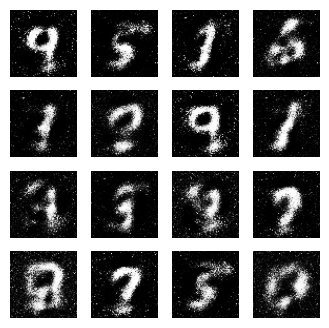

Epoch 11, Loss: D=1.1134, G=1.4587


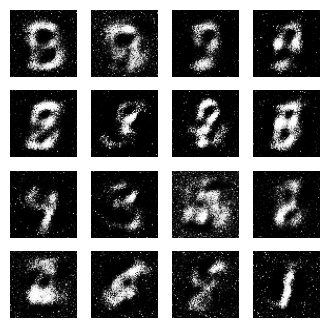

Epoch 12, Loss: D=1.1877, G=1.0755


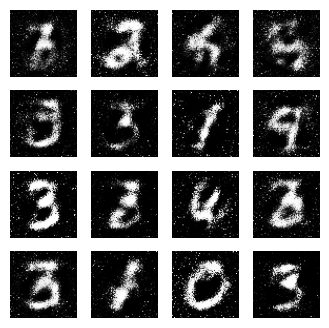

Epoch 13, Loss: D=1.1197, G=1.3193


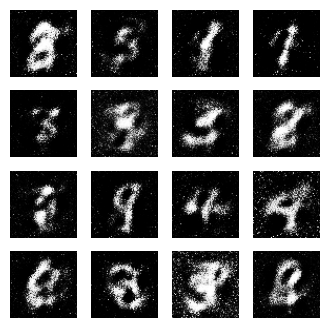

Epoch 14, Loss: D=1.1163, G=1.1415


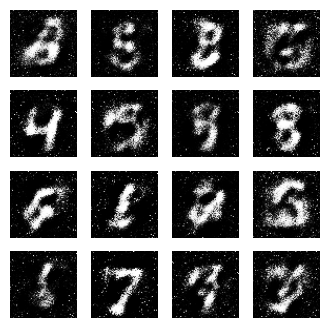

Epoch 15, Loss: D=1.1156, G=1.0576


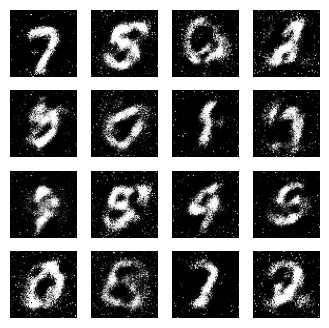

Epoch 16, Loss: D=1.1689, G=0.8956


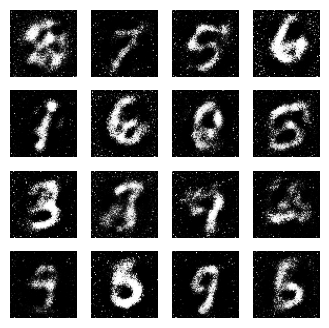

Epoch 17, Loss: D=1.2002, G=1.0763


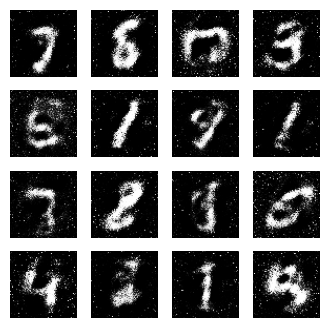

Epoch 18, Loss: D=1.3000, G=0.6047


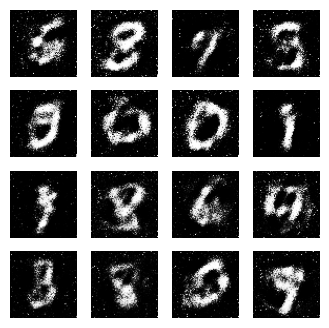

Epoch 19, Loss: D=1.1827, G=1.1273


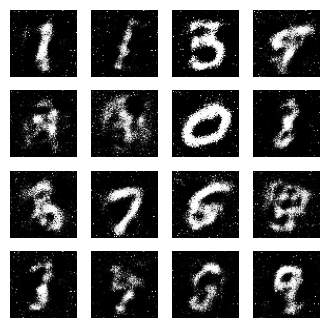

Epoch 20, Loss: D=1.2376, G=1.0017


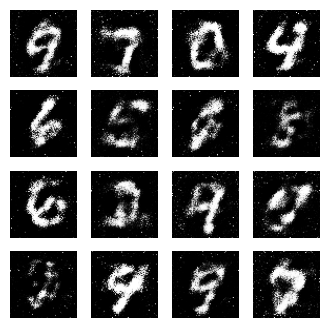

Epoch 21, Loss: D=1.2065, G=1.0315


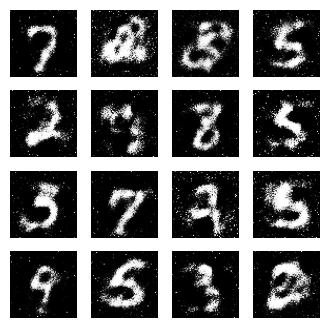

Epoch 22, Loss: D=1.2917, G=1.0301


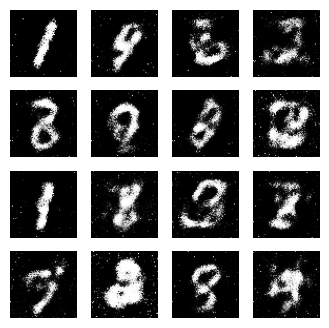

Epoch 23, Loss: D=1.2368, G=0.8841


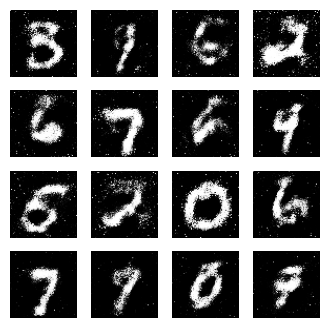

Epoch 24, Loss: D=1.3301, G=0.6838


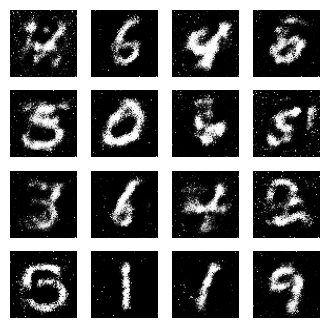

Epoch 25, Loss: D=1.3185, G=0.7585


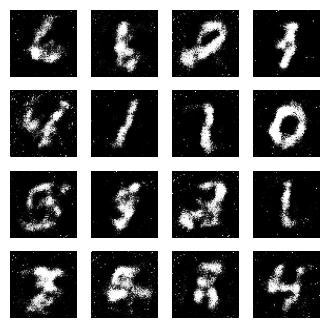

Epoch 26, Loss: D=1.2568, G=0.7992


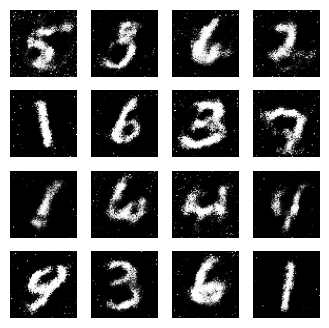

Epoch 27, Loss: D=1.3052, G=0.7853


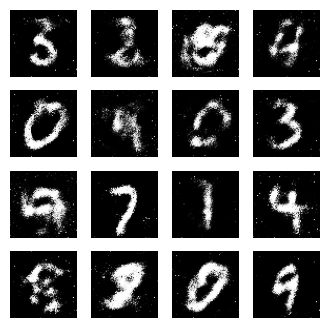

Epoch 28, Loss: D=1.3877, G=0.7251


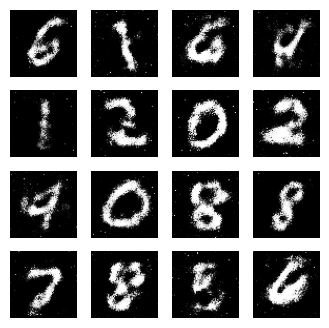

Epoch 29, Loss: D=1.2914, G=0.7372


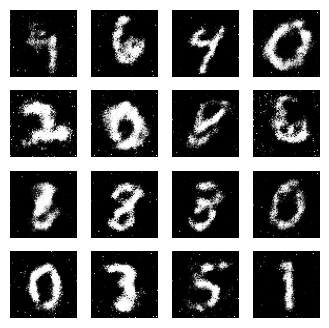

Epoch 30, Loss: D=1.4122, G=0.7131


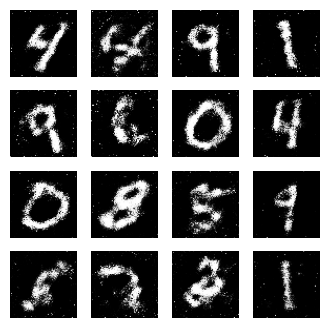

Epoch 31, Loss: D=1.3646, G=0.8333


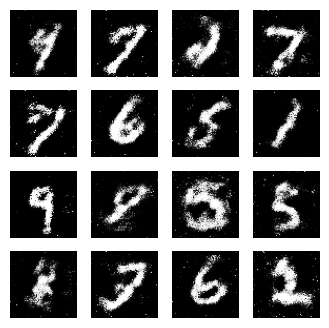

Epoch 32, Loss: D=1.3287, G=0.7663


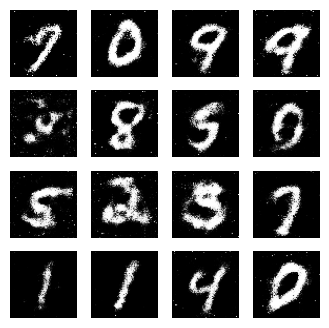

Epoch 33, Loss: D=1.3485, G=0.8082


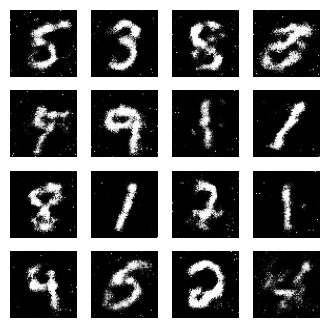

Epoch 34, Loss: D=1.3486, G=0.8117


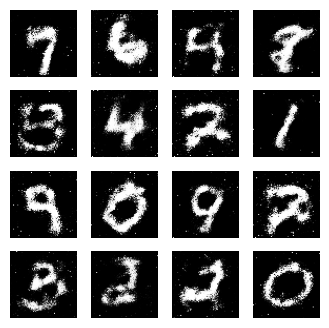

Epoch 35, Loss: D=1.3949, G=0.7277


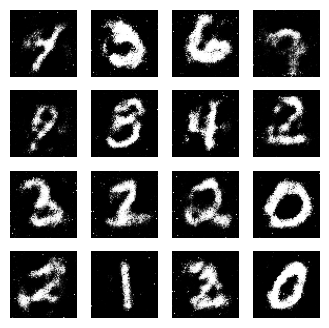

Epoch 36, Loss: D=1.3904, G=0.8176


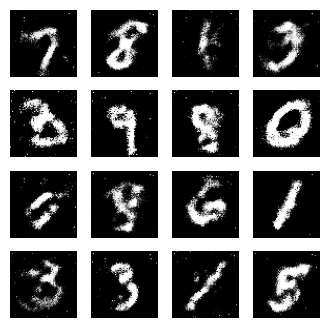

Epoch 37, Loss: D=1.3516, G=0.7700


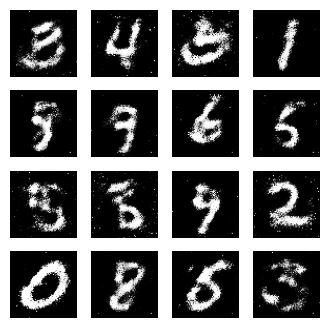

Epoch 38, Loss: D=1.3569, G=0.7695


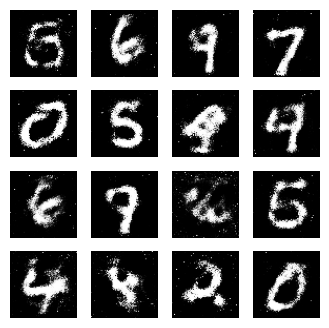

Epoch 39, Loss: D=1.3691, G=0.7882


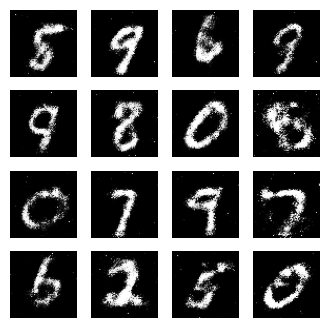

Epoch 40, Loss: D=1.4006, G=0.8326


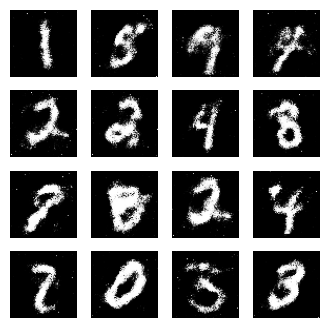

Epoch 41, Loss: D=1.3506, G=0.7172


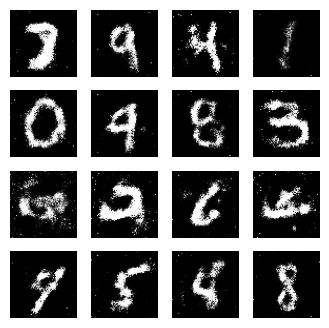

Epoch 42, Loss: D=1.3694, G=0.8127


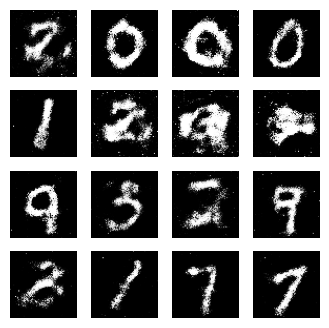

Epoch 43, Loss: D=1.3672, G=0.7125


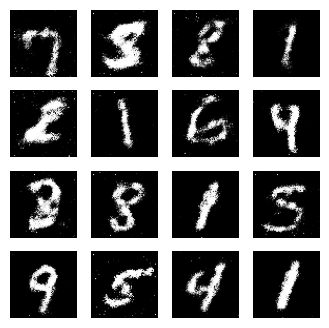

Epoch 44, Loss: D=1.3875, G=0.7758


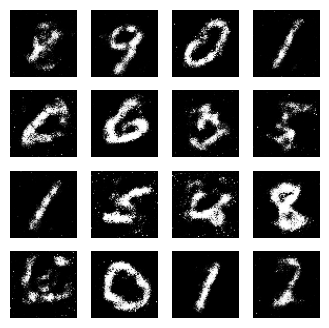

Epoch 45, Loss: D=1.3611, G=0.7827


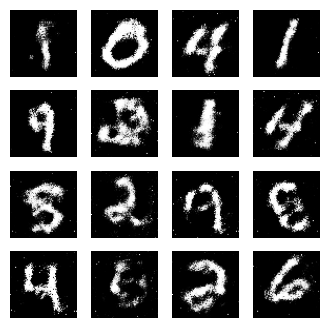

Epoch 46, Loss: D=1.3773, G=0.7011


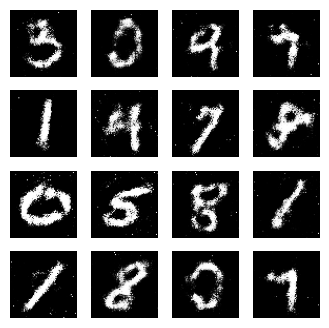

Epoch 47, Loss: D=1.3833, G=0.7218


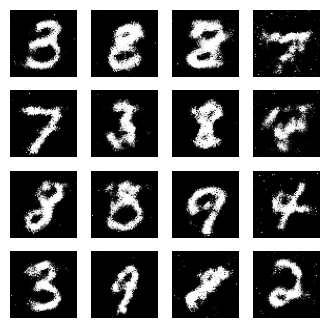

Epoch 48, Loss: D=1.3656, G=0.6777


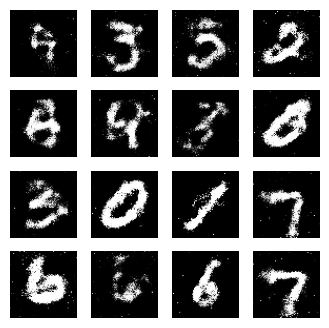

Epoch 49, Loss: D=1.3683, G=0.7320


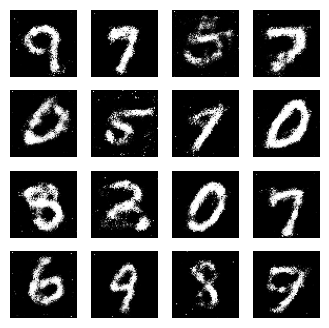

Epoch 50, Loss: D=1.3843, G=0.7386


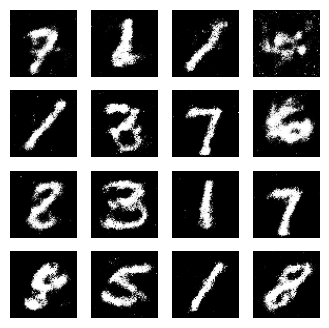

DEBUG:h5py._conv:Creating converter from 5 to 3


In [7]:
import os
import logging
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Configuração do TensorFlow para evitar alocação excessiva de memória
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configuração de logs
logging.basicConfig(level=logging.DEBUG)

# Hiperparâmetros
batch_size = 128
noise_dim = 100
img_size = 64
epochs = 50
learning_rate = 2e-4
beta_1 = 0.5
classes = 10
channels = 1

# Otimizadores
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=beta_1)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def generate_and_save_images(model, labels, epoch):
    noise = tf.random.normal([16, noise_dim])  # Gerando um pequeno lote para exibição
    predictions = model([noise, labels[:16]], training=False)

    # **Correção**: Ajustar a saída do gerador para o formato correto
    predictions = tf.reshape(predictions, [-1, img_size, img_size])

    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.show()


def define_discriminator():
    image_input = layers.Input(shape=(img_size * img_size,))
    label_input = layers.Input(shape=(classes,))
    disc_input = layers.Concatenate()([image_input, label_input])

    x = layers.Dense(batch_size * 2, use_bias=True)(disc_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Dense(batch_size, use_bias=True)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.LeakyReLU(0.2)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([image_input, label_input], output)


def define_generator():
    noise_input = layers.Input(shape=(noise_dim,))
    label_input = layers.Input(shape=(classes,))
    gen_input = layers.Concatenate()([noise_input, label_input])

    x = layers.Dense(batch_size, use_bias=True)(gen_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Dense(batch_size * 2, use_bias=True)(x)
    x = layers.BatchNormalization(momentum=0.1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Dense(batch_size * 2 * 2, use_bias=True)(x)
    x = layers.BatchNormalization(momentum=0.1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Dense(img_size * img_size, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], x)


# Carregar e pré-processar os dados (usando MNIST)
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0
train_images = (train_images - 0.5) / 0.5  # Normalizar entre [-1, 1]
train_images = tf.image.resize(tf.expand_dims(train_images, axis=-1), [img_size, img_size])
train_images = tf.reshape(train_images, [-1, img_size * img_size])

# Criar dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(60000).batch(batch_size)

# Criar modelos
generator = define_generator()
discriminator = define_discriminator()

# Loop de Treinamento
for epoch in range(epochs):
    for real_images, real_labels in dataset:
        noise = tf.random.normal([batch_size, noise_dim])
        fake_labels = tf.one_hot(tf.random.uniform([batch_size], minval=0, maxval=classes, dtype=tf.int32), classes)
        real_labels_one_hot = tf.one_hot(real_labels, classes)

        # Treinar Discriminador
        with tf.GradientTape() as disc_tape:
            generated_images = generator([noise, fake_labels], training=True)
            real_output = discriminator([real_images, real_labels_one_hot], training=True)
            fake_output = discriminator([generated_images, fake_labels], training=True)
            disc_loss = discriminator_loss(real_output, fake_output)

        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        # Treinar Gerador
        with tf.GradientTape() as gen_tape:
            generated_images = generator([noise, fake_labels], training=True)
            fake_output = discriminator([generated_images, fake_labels], training=True)
            gen_loss = generator_loss(fake_output)

        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

    # Gerar imagens após cada época
    print(f"Epoch {epoch + 1}, Loss: D={disc_loss:.4f}, G={gen_loss:.4f}")
    generate_and_save_images(generator, fake_labels, epoch + 1)

# Salvar modelos
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")


In [8]:
import keras.saving
keras.saving.save_model(generator, "generator_model.keras")
keras.saving.save_model(discriminator, "discriminator_model.keras")


### Carregando o modelo treinado

In [ ]:
# from tensorflow import keras
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Carregar o gerador treinado
# generator = keras.models.load_model("generator_model.keras")


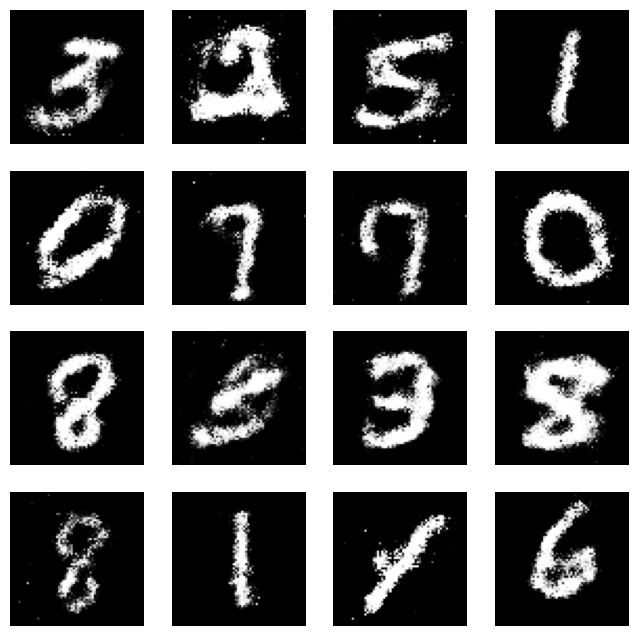

In [ ]:
# # Hiperparâmetros
# batch_size = 16  # Quantidade de imagens a gerar
# noise_dim = 100  # Dimensão do ruído
# classes = 10  # Número de classes no MNIST

# # Gerar ruído aleatório
# noise = tf.random.normal([batch_size, noise_dim])

# # Criar rótulos aleatórios para os números gerados (de 0 a 9)
# random_labels = tf.random.uniform([batch_size], minval=0, maxval=classes, dtype=tf.int32)

# # Converter os rótulos para one-hot encoding
# random_labels_one_hot = tf.one_hot(random_labels, depth=classes)

# # Gerar imagens com o modelo treinado
# generated_images = generator([noise, random_labels_one_hot], training=False)

# # Redimensionar para formato de imagem
# generated_images = tf.reshape(generated_images, [-1, 64, 64])

# # Exibir imagens geradas
# fig, axes = plt.subplots(4, 4, figsize=(8, 8))
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(generated_images[i] * 127.5 + 127.5, cmap='gray')
#     ax.axis('off')

# plt.show()


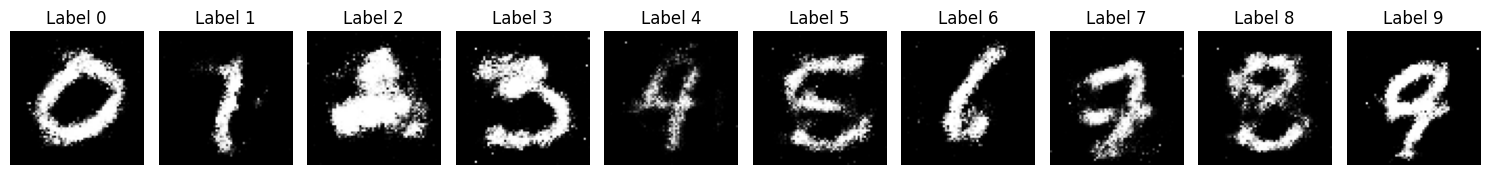

In [5]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

# Carregar o modelo gerador treinado
generator = keras.models.load_model("generator_model.keras")

# Hiperparâmetros
noise_dim = 100
classes = 10  # MNIST tem 10 classes (0 a 9)

# Criar ruído aleatório para cada número (10 amostras, uma para cada classe)
noise = tf.random.normal([classes, noise_dim])

# Criar rótulos correspondentes (de 0 a 9) e convertê-los para one-hot encoding
labels = tf.range(0, classes)  # Cria [0,1,2,3,4,5,6,7,8,9]
labels_one_hot = tf.one_hot(labels, depth=classes)

# Gerar imagens com o modelo treinado
generated_images = generator([noise, labels_one_hot], training=False)

# Redimensionar para formato de imagem
generated_images = tf.reshape(generated_images, [-1, 64, 64])

# Exibir as imagens geradas
fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # 1 linha, 10 colunas

for i in range(classes):
    axes[i].imshow(generated_images[i] * 127.5 + 127.5, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label {i}")  # Exibir rótulo acima da imagem

plt.tight_layout()
plt.show()


### Calculando a qualidade da imagem sintética - Inception Score (IS)

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy.stats
import matplotlib.pyplot as plt

# 📌 Carregar o gerador treinado
generator = keras.models.load_model("generator_model.keras")

# 📌 Hiperparâmetros
num_samples = 500  # Número de imagens a gerar
batch_size = 50    # Tamanho do lote para avaliação
noise_dim = 100    # Dimensão do vetor de ruído
classes = 10       # Número de classes MNIST

# 📌 Carregar modelo InceptionV3 pré-treinado (sem a camada final)
inception_model = InceptionV3(include_top=True, weights="imagenet")
inception_model = keras.Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)

# 📌 Função para calcular o Inception Score
def calculate_inception_score(images, num_splits=10):
    """
    Calcula o Inception Score (IS) das imagens geradas.
    :param images: Imagens geradas (tensor numpy)
    :param num_splits: Número de divisões para calcular estatísticas
    :return: Inception Score médio e desvio padrão
    """
    # Normalizar as imagens para o formato do InceptionV3 (3 canais RGB)
    images = np.stack([np.stack([img] * 3, axis=-1) for img in images], axis=0)
    images = preprocess_input(images)  # Normaliza para o InceptionV3

    # Obter previsões do modelo InceptionV3
    preds = inception_model.predict(images, batch_size=batch_size)

    # Calcular probabilidades
    p_yx = tf.nn.softmax(preds).numpy()
    p_y = np.mean(p_yx, axis=0)

    # Calcular a divergência KL para cada amostra
    kl_div = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
    kl_div = np.sum(kl_div, axis=1)

    # Calcular score para cada divisão
    scores = []
    split_size = num_samples // num_splits
    for i in range(num_splits):
        part = kl_div[i * split_size : (i + 1) * split_size]
        scores.append(np.exp(np.mean(part)))

    return np.mean(scores), np.std(scores)

# 📌 Gerar imagens para avaliação
noise = tf.random.normal([num_samples, noise_dim])
labels = tf.random.uniform([num_samples], minval=0, maxval=classes, dtype=tf.int32)
labels_one_hot = tf.one_hot(labels, depth=classes)
generated_images = generator([noise, labels_one_hot], training=False)

# 📌 Redimensionar imagens para (299x299) para o InceptionV3
# generated_images = tf.image.resize(generated_images, [299, 299])
# 1️⃣ Redimensionar para 4D (batch, altura, largura, canais)
generated_images = tf.reshape(generated_images, [-1, 64, 64, 1])  
generated_images = tf.squeeze(generated_images, axis=-1)  # Remover dimensão extra

# 📌 Calcular o Inception Score
mean_is, std_is = calculate_inception_score(generated_images.numpy())

# 📌 Exibir resultado
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(50, 64, 64, 3)

In [8]:
import numpy
import scipy

print("NumPy versão:", numpy.__version__)
print("SciPy versão:", scipy.__version__)


NumPy versão: 1.26.0
SciPy versão: 1.10.1


In [11]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy.stats
import matplotlib.pyplot as plt

# 📌 Carregar o gerador treinado
generator = keras.models.load_model("generator_model.keras")

# 📌 Hiperparâmetros
num_samples = 500  # Número de imagens a gerar
batch_size = 50    # Tamanho do lote para avaliação
noise_dim = 100    # Dimensão do vetor de ruído
classes = 10       # Número de classes MNIST

# 📌 Carregar modelo InceptionV3 pré-treinado (sem a camada final)
inception_model = InceptionV3(include_top=True, weights="imagenet")
inception_model = keras.Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)

# 📌 Função para calcular o Inception Score
def calculate_inception_score(images, num_splits=10):
    """
    Calcula o Inception Score (IS) das imagens geradas.
    :param images: Imagens geradas (tensor numpy)
    :param num_splits: Número de divisões para calcular estatísticas
    :return: Inception Score médio e desvio padrão
    """
    # Normalizar as imagens para o formato do InceptionV3 (3 canais RGB)
    images = preprocess_input(images)  # Normaliza para o InceptionV3

    # Obter previsões do modelo InceptionV3
    preds = inception_model.predict(images, batch_size=batch_size)

    # Calcular probabilidades
    p_yx = tf.nn.softmax(preds).numpy()
    p_y = np.mean(p_yx, axis=0)

    # Calcular a divergência KL para cada amostra
    kl_div = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
    kl_div = np.sum(kl_div, axis=1)

    # Calcular score para cada divisão
    scores = []
    split_size = num_samples // num_splits
    for i in range(num_splits):
        part = kl_div[i * split_size : (i + 1) * split_size]
        scores.append(np.exp(np.mean(part)))

    return np.mean(scores), np.std(scores)

# 📌 Gerar imagens para avaliação
noise = tf.random.normal([num_samples, noise_dim])
labels = tf.random.uniform([num_samples], minval=0, maxval=classes, dtype=tf.int32)
labels_one_hot = tf.one_hot(labels, depth=classes)
generated_images = generator([noise, labels_one_hot], training=False)

# 📌 Ajustar formato das imagens para InceptionV3
generated_images = tf.reshape(generated_images, [-1, 64, 64, 1])  # Garantir dimensão correta
generated_images = tf.image.grayscale_to_rgb(generated_images)  # Converter para RGB
generated_images = tf.image.resize(generated_images, [299, 299])  # Redimensionar para 299x299

# 📌 Calcular o Inception Score
mean_is, std_is = calculate_inception_score(generated_images.numpy())

# 📌 Exibir resultado
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 893ms/step
Inception Score: 1.0164 ± 0.0017


### Calculando a qualidade da imagem sintética - Frechet Inception Distance (FID)

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm  # Para matriz raiz quadrada
import matplotlib.pyplot as plt

# 📌 Carregar o gerador treinado
generator = keras.models.load_model("generator_model.keras")

# 📌 Hiperparâmetros
num_samples = 500  # Número de imagens a gerar
batch_size = 50    # Tamanho do lote para avaliação
noise_dim = 100    # Dimensão do vetor de ruído
classes = 10       # Número de classes MNIST

# 📌 Carregar modelo InceptionV3 pré-treinado (sem a camada final)
inception_model = InceptionV3(include_top=False, pooling='avg', weights="imagenet")

# 📌 Função para calcular média e covariância das features
def calculate_activation_statistics(images):
    """
    Calcula a média (mu) e a covariância (sigma) das features extraídas pelo InceptionV3.
    :param images: Imagens de entrada (batch, altura, largura, canais)
    :return: média (mu), covariância (sigma)
    """
    images = preprocess_input(images)  # Normaliza para o InceptionV3
    activations = inception_model.predict(images, batch_size=batch_size)
    
    mu = np.mean(activations, axis=0)  # Média das features
    sigma = np.cov(activations, rowvar=False)  # Covariância das features

    return mu, sigma

# 📌 Função para calcular a Frechet Inception Distance (FID)
def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calcula a distância de Fréchet entre duas distribuições Gaussianas.
    :param mu1, sigma1: Média e covariância das features do conjunto real
    :param mu2, sigma2: Média e covariância das features do conjunto gerado
    :return: FID score
    """
    # || mu1 - mu2 ||^2
    diff = np.sum((mu1 - mu2) ** 2)

    # sqrtm(sigma1 * sigma2)
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    # Se houver valores complexos na matriz, apenas pegue a parte real
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# 📌 Carregar e pré-processar imagens reais do MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0
train_images = (train_images - 0.5) / 0.5  # Normalizar entre [-1, 1]

# 📌 Selecionar apenas um subconjunto pequeno do MNIST
num_real_samples = 500  # Processar apenas 500 imagens reais para evitar OOM
train_images = train_images[:num_real_samples]

train_images = tf.image.resize(tf.expand_dims(train_images, axis=-1), [64, 64])
train_images = tf.image.grayscale_to_rgb(train_images)  # Converter para RGB
train_images = tf.image.resize(train_images, [299, 299])  # Redimensionar para 299x299

# Selecionar um subconjunto das imagens reais
real_images = train_images[:num_samples]

# 📌 Gerar imagens sintéticas para avaliação
noise = tf.random.normal([num_samples, noise_dim])
labels = tf.random.uniform([num_samples], minval=0, maxval=classes, dtype=tf.int32)
labels_one_hot = tf.one_hot(labels, depth=classes)
generated_images = generator([noise, labels_one_hot], training=False)

# 📌 Ajustar formato das imagens geradas para InceptionV3
generated_images = tf.reshape(generated_images, [-1, 64, 64, 1])  # Garantir dimensão correta
generated_images = tf.image.grayscale_to_rgb(generated_images)  # Converter para RGB
generated_images = tf.image.resize(generated_images, [299, 299])  # Redimensionar para 299x299

# 📌 Calcular estatísticas das features
mu_real, sigma_real = calculate_activation_statistics(real_images.numpy())
mu_fake, sigma_fake = calculate_activation_statistics(generated_images.numpy())

# 📌 Calcular o FID
fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

# 📌 Exibir resultado
print(f"Frechet Inception Distance (FID): {fid_score:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 891ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 898ms/step
Frechet Inception Distance (FID): 44.4460
